In [1]:
import requests
import pandas as pd

In [2]:
DewanRakyatID = '53633b5a19ee29270d8a9ecf'
url = 'http://api.popit.sinarproject.org/en/organizations/'+ DewanRakyatID+ "/?minify=True"
r = requests.get(url).json()['result'] 
#Get membership IDs of all current and ex-members of Dewan Rakyat
membershipIDs = r['memberships']


### Getting all current Members of Parliament

All members without an end date for their post are considered as current members. We'll write a simple loop through our members list to extract all the current parliamentarians.

In [3]:
currentMembers = []

for membership_id in membershipIDs:
        url = 'http://api.popit.sinarproject.org/en/memberships/'+ membership_id
        member = requests.get(url).json()['result']

        #Get current members
        end_date = member['end_date']
        
        if end_date: #has end date, ex member
            pass    
        else: #current member
            currentMembers.append(member)

Turning our dictionary object into a Pandas dataframe, with the keys of the response payload as the columns for our new dataframe:

In [4]:
currMems = pd.Series(currentMembers).to_dict()
df = pd.DataFrame.from_dict(currMems, orient = 'index')
df.head() #Preview

,on_behalf_of,person,label,organization_id,on_behalf_of_id,links,updated_at,post_id,start_date,member_id,...,organization,role,language_code,person_id,contact_details,id,post,member,area_id,created_at
0,"{'language_code': 'en', 'updated_at': '2016-07...","{'sort_name': None, 'identifiers': [], 'additi...",None,53633b5a19ee29270d8a9ecf,5362fcc219ee29270d8a9e22,[],2017-04-04T03:52:06.924070Z,5367299319ee29270d8a9f51,2013-06-24,None,...,"{'language_code': 'en', 'updated_at': '2016-07...",Member of Parliament,en,545e47b85222837c2c0594e2,[],5510c2d7a344efdd478420c9,"{'language_code': 'en', 'area_id': 'b4db65dfab...",None,None,2015-12-21T03:19:23.402692Z
1,"{'language_code': 'en', 'updated_at': '2015-12...","{'sort_name': None, 'identifiers': [], 'additi...",None,53633b5a19ee29270d8a9ecf,53631a3619ee29270d8a9e90,[],2017-03-16T05:07:25.326217Z,53633fbb19ee29270d8a9ee1,2013-06-24,None,...,"{'language_code': 'en', 'updated_at': '2016-07...",Member of Parliament,en,545e48755222837c2c0596a7,[],555c0f25b48c37522142ecc3,"{'language_code': 'en', 'area_id': 'b1123f0ef9...",None,None,2015-12-21T02:02:24.869249Z
2,"{'language_code': 'en', 'updated_at': '2015-12...","{'sort_name': None, 'identifiers': [], 'additi...",None,53633b5a19ee29270d8a9ecf,536361b519ee29270d8a9eeb,[],2017-03-16T05:04:54.276257Z,5365cb5219ee29270d8a9f13,2013-06-24,None,...,"{'language_code': 'en', 'updated_at': '2016-07...",Member of Parliament,en,545e46415222837c2c05913a,[],555d56359f9585d252b6de67,"{'language_code': 'en', 'area_id': '941a7ea55b...",None,None,2015-12-21T07:11:59.264608Z
3,"{'language_code': 'en', 'updated_at': '2015-12...","{'sort_name': None, 'identifiers': [], 'additi...",None,53633b5a19ee29270d8a9ecf,545de8665222837c2c0586c0,[],2017-03-16T05:05:28.939831Z,53633d1719ee29270d8a9ed4,2015-05-08,None,...,"{'language_code': 'en', 'updated_at': '2016-07...",Member of Parliament,en,545e43525222837c2c0589eb,[],55666d035ea60e3d2501bb08,"{'language_code': 'en', 'area_id': '490859a3c4...",None,None,2015-12-21T02:14:23.853752Z
4,"{'language_code': 'en', 'updated_at': '2015-12...","{'sort_name': None, 'identifiers': [], 'additi...",None,53633b5a19ee29270d8a9ecf,536361b519ee29270d8a9eeb,[],2017-03-16T05:05:19.226834Z,5365de7719ee29270d8a9f2a,2013-06-24,None,...,"{'language_code': 'en', 'updated_at': '2016-07...",Member of Parliament,en,545e46e35222837c2c0592d0,[],55666f04364d1ba921838e71,"{'language_code': 'en', 'area_id': 'd25ce22631...",None,None,2015-12-21T07:12:17.497832Z


### Expand contents of nested columns
Due to the nested nature of the API response, we'll flatten the contents of a few select columns by first extracting the contents of the Persons, Posts and On Behalf Of columns which contains nested dictionaries, and converting it into new dataframes:

In [5]:
personsdf = pd.DataFrame.from_dict(df['person'].to_dict(), orient = 'index')
personsdf.drop('id', axis=1, inplace=True)  #drop to avoid overlap with alread existing persons_id in df

#Get post df
postdf = pd.DataFrame.from_dict(df['post'].to_dict(), orient = 'index')

#Get on_behalf_of df
df['on_behalf_of'] = df['on_behalf_of'].apply(lambda x: {} if pd.isnull(x) else x)
on_behalf_of_df = pd.DataFrame.from_dict(df['on_behalf_of'].to_dict(), orient = 'index')

And then joining the extracted dataframes with our original dataframe to give us a flat representation that combines information from all classes. This is similar to what was demonstrated in [Working with Popit API and Pandas](https://github.com/kay-wong/kay-wong/blob/master/Working%2Bwith%2BPopit%2BAPI%2Band%2BPandas.ipynb).

In [6]:
personsdf.columns = ['person_'+colName for colName in personsdf.columns] #add 'person' suffix to column names of personsdf

df =  df.join(personsdf, how = 'outer')
df['post_label'] =  postdf['label']
df['on_behalf_of'] = on_behalf_of_df['name']

Obtaining the contact details for each MP is less straightforward than what we did earlier for Posts and Persons, as the contacts class has an uneven number of fields, unlike that for posts and persons. For this we will have to apply a getContacts function on each row individually.

In [11]:
personContacts = personsdf['person_contact_details']
contactKeys  = ['contact_twitter','contact_email', 'contact_cell', 'contact_voice', 'contact_fax', 'contact_address']
    
def getContacts(contact_detail):    
    contacts = {}
    #Initialize contacts dic with fixed number of fields
    contactKeys  = ['contact_twitter','contact_email', 'contact_cell', 'contact_voice', 'contact_fax', 'contact_address']
    contactVals=  [""]*len(contactKeys)
    contacts = dict(zip(contactKeys, contactVals))
    #Update contact values
    for c in contact_detail:
        key = 'contact_'+ c['type']
        if key in contactKeys:
            contacts[key] = c['value']

    return contacts

personContacts = personContacts.apply(getContacts)
personContacts = pd.DataFrame.from_dict(personContacts.to_dict(), orient= 'index')

personContacts.head()

#Join personContacts with our original df
df = df.join(personContacts, how = 'outer')

## Analysis of female MPs
Now we can do some analyses on parliamentarians across different classes. 

In [12]:
#For plotting
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#### Get percentage of women MPs in current Parliament.

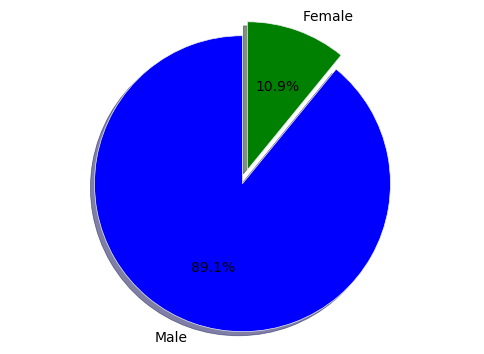

In [13]:
gender_ratio = df['person_gender'].value_counts()
explode = (0, 0.1)  #only "explode" the 'Female' slice
fig1, ax1 = plt.subplots()
ax1.pie(gender_ratio, explode = explode, labels=gender_ratio.keys(), autopct='%1.1f%%',
        shadow=True, startangle=90)

ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

#### A closer examination of female MP entries

In [14]:
#Get dataframe of female MPs
femaleMPs = df[df['person_gender']== 'Female']
#Index a few columns to examine
femaleMPs[['person_name', 'person_gender', 'person_national_identity', 'person_birth_date', 'start_date', 'post_label', 'on_behalf_of']]

,person_name,person_gender,person_national_identity,person_birth_date,start_date,post_label,on_behalf_of
3,Wan Azizah Wan Ismail,Female,Malay,1952-12-03,2015-05-08,MP for Permatang Pauh,Parti Keadilan Rakyat
14,Nurul Izzah Anwar,Female,None,1980-11-19,2013-06-24,MP for Lembah Pantai,Parti Keadilan Rakyat
15,Teresa Kok Suh Sim,Female,Chinese,1964-03-31,2013-06-24,MP for Seputeh,Democratic Action Party
25,Mas Ermieyati Samsudin,Female,None,1976-11-13,2013-06-24,MP for Masjid Tanah,United Malays National Organization
39,Noraini Ahmad,Female,None,1967-11-07,2013-06-24,MP for Parit Sulong,United Malays National Organization
45,Halimah Mohamed Sadique,Female,None,1962-02-02,2013-06-24,MP for Tenggara,United Malays National Organization
47,Azalina Othman Said,Female,Malay,1963-12-31,2013-06-24,MP for Pengerang,United Malays National Organization
48,Normala Abdul Samad,Female,None,None,2013-06-24,MP for Pasir Gudang,United Malays National Organization
51,Teo Nie Ching,Female,Chinese,1981-01-27,2013-06-24,MP for Kulai,Democratic Action Party
62,Rosnah Abdul Rashid Shirlin,Female,None,1972-07-10,2013-06-24,MP for Papar,United Malays National Organization


#### Racial makeup of female MPs of current parliament

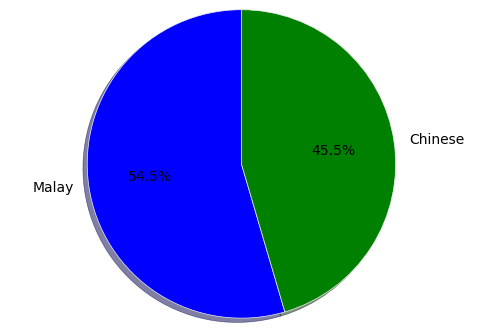

In [15]:
femaleMP_race = femaleMPs['person_national_identity'].value_counts()

fig1, ax2 = plt.subplots()
ax2.pie(femaleMP_race, labels=femaleMP_race.keys(), autopct='%1.1f%%',
        shadow= True, startangle=90)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

#### Party makeup of female MPs of current parliament

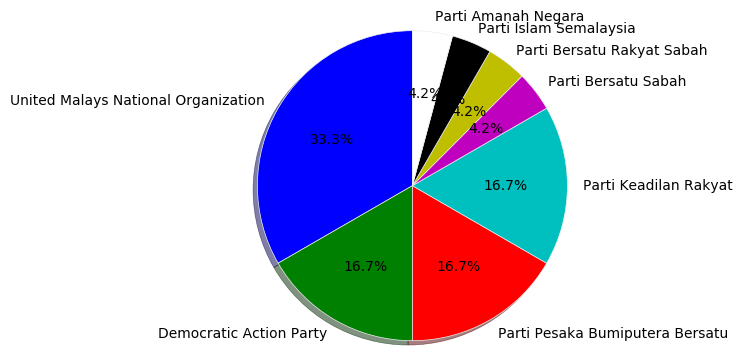

In [16]:
femaleMP_party = femaleMPs['on_behalf_of'].value_counts()

fig1, ax3 = plt.subplots()
ax3.pie(femaleMP_party, labels=femaleMP_party.keys(), autopct='%1.1f%%',
        shadow= True, startangle=90)
ax3.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

#### Contact details for all female MPs

In [17]:
femaleMP_contacts = femaleMPs.filter(regex = r'^contact_')
femaleMPs[['person_name', 'post_label', 'on_behalf_of']].join(femaleMP_contacts, how= 'outer')

,person_name,post_label,on_behalf_of,contact_details,contact_cell,contact_address,contact_email,contact_fax,contact_twitter,contact_voice
3,Wan Azizah Wan Ismail,MP for Permatang Pauh,Parti Keadilan Rakyat,[],,"Ibu Pejabat Parti Keadilan Rakyat, A-1-09 Merc...",nonaziza@gmail.com,03-7885 0531,drwanaziza,03-7885 0530
14,Nurul Izzah Anwar,MP for Lembah Pantai,Parti Keadilan Rakyat,[],,"No. 1-2 Jalan Pantai Murni 6, Pantai Dalam, ...",,,n_izzah,03-22409475
15,Teresa Kok Suh Sim,MP for Seputeh,Democratic Action Party,[],,"28-3a, 4th Floor Sri Desa Entrepreneur's Park ...",,,teresakok,03-79836768
25,Mas Ermieyati Samsudin,MP for Masjid Tanah,United Malays National Organization,[],,"MT 2193 Jalan Taman Bandar Baru, 78300 Masjid ...",amysudin2@yahoo.com,,emysamsudin,06-3846050
39,Noraini Ahmad,MP for Parit Sulong,United Malays National Organization,[],,62a Jalan Sepah Puteri 5/24 Kota Damansara 478...,,,,07-4380666
45,Halimah Mohamed Sadique,MP for Tenggara,United Malays National Organization,[],,"Kkbpkt Aras 18, No 51 Persiaran Perdana, Presi...",halimah.sadique@kpkt.gov.my,,,03-88915027
47,Azalina Othman Said,MP for Pengerang,United Malays National Organization,[],,"No 10, Jalan Laksamana 12/1, Seksyen 12, 40000...",donhezry@gmail.com,,Azalina,07-8953397
48,Normala Abdul Samad,MP for Pasir Gudang,United Malays National Organization,[],,No. 20 Jalan Suria 64 Bandar Sri Alam 81750 Ma...,mala1809@yahoo.com,,normalasamad,07-3881735
51,Teo Nie Ching,MP for Kulai,Democratic Action Party,[],,"No. 21-1 Jalan Tropikal Taman Tropika, 81000 K...",teoniecheng@gmail.com / teoniecheng.office@gma...,,teonieching,03-95446720
62,Rosnah Abdul Rashid Shirlin,MP for Papar,United Malays National Organization,[],,"Kementerian Kerja Raya, Tingkat 5, Blok A Komp...",rosnahshirlin@yahoo.com,,Rosnah_ARS,03-27714010
